# 1. Load the dataset

In [1]:
def inverse_normalize(normalized, min_val, max_val):
    return ((normalized + 1) / 2) * (max_val - min_val) + min_val

In [2]:
from torch.utils import data
from JGC_MMN_dataloader import JGC_MMN_dataloader

In [3]:
train_dataset = JGC_MMN_dataloader(
        name=["long_term.npy", "short_term.npy", "ingredients.npy", "future.npy", "label.npy"],
        root="/Users/gunneo/Documents/4_2/Graduation_Thesis/Datasets/NYC_House_Price_Dataset/JGC_MMN/train",
        transaction_cnt=False,
    )
train_dataloader = data.DataLoader(train_dataset, batch_size=117, shuffle=True)
img_h = train_dataloader.dataset[0][0].shape[1]
img_w = train_dataloader.dataset[0][0].shape[2]
long_term_in_channels = train_dataloader.dataset[0][0].shape[0]
short_term_in_channels = train_dataloader.dataset[0][1].shape[0]
cur_ingred_dim = train_dataloader.dataset[0][2].shape[0]

print(img_h, img_w, long_term_in_channels, short_term_in_channels, cur_ingred_dim)

20 20 2 12 9


# 2. Initialize the model

In [4]:
from JGC_MMN import JGC_MMN

In [5]:
train_model = JGC_MMN(
    branches = [0, 1, 2],
    dense_ori=True,
    # img config
    img_h = img_h,
    img_w = img_w,
    # short term config
    short_term_in_channels = short_term_in_channels,
    short_term_growth_rate = 4,
    short_term_block_config = (6, 12, 24, 16),
    # long term config
    long_term_in_channels = long_term_in_channels,
    long_term_growth_rate = 4,
    long_term_block_config = (6, 12, 24, 16),
    # cur ingredient config
    ingred_dense=False,
    cur_ingred_dim = cur_ingred_dim,
    emedding_dim = 64,
    # future price growth expectation config
    # fusion config
    modalities = 3,
    indexs = [0, 1],
)

In [ ]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, RMSprop, Adagrad
import matplotlib.pyplot as plt

def rmse_loss(pred, target):
    mse = nn.MSELoss()
    return torch.sqrt(mse(pred, target))

def train(
        model,
        train_dataloader,
        w_path,
        num_epochs=50,
        optimizer_type='adam',
        lr=5e-4,
        input_indices=[0, 1, 2, 3],
        patience=5,
        save_interval=25,
        loss_threshold=1e-4
        ):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    loss_history = []
        
    optimizers = {
        'adam': Adam(model.parameters(), lr=lr),
        'sgd': SGD(model.parameters(), lr=lr, momentum=0.9),
        'rmsprop': RMSprop(model.parameters(), lr=lr),
        'adagrad': Adagrad(model.parameters(), lr=lr)
    }
    if optimizer_type not in optimizers:
        raise ValueError("Unsupported optimizer type")
    optimizer = optimizers[optimizer_type]

    best_model_path = os.path.join(w_path, "best_model.pth")
    best_loss = float('inf')
    no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        
        for batch in train_dataloader:
            inputs = [batch[i].to(device) for i in input_indices]
            labels = batch[-1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = rmse_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item() * labels.size(0)
        
        epoch_train_loss /= len(train_dataloader.dataset)
        loss_history.append(epoch_train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_train_loss:.4f}")

        if epoch_train_loss < best_loss - loss_threshold:
            best_loss = epoch_train_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved to {best_model_path} with loss {best_loss:.4f}")
            no_improve = 0
        else:
            no_improve += 1
            print(f"No improvement for {no_improve}/{patience} epochs")
            if no_improve > patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if save_interval > 0 and (epoch + 1) % save_interval == 0:
            checkpoint_path = os.path.join(w_path, f"checkpoint_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, 'b-')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    print("Training complete.")

Epoch [1/500] Train Loss: 1.1337
Best model saved to /Users/gunneo/Documents/4_2/Graduation_Thesis/Datasets/NYC_House_Price_Dataset/JGC_MMN/train_weights/best_model.pth with loss 1.1337
Epoch [2/500] Train Loss: 0.9976
Best model saved to /Users/gunneo/Documents/4_2/Graduation_Thesis/Datasets/NYC_House_Price_Dataset/JGC_MMN/train_weights/best_model.pth with loss 0.9976
Epoch [3/500] Train Loss: 0.8562
Best model saved to /Users/gunneo/Documents/4_2/Graduation_Thesis/Datasets/NYC_House_Price_Dataset/JGC_MMN/train_weights/best_model.pth with loss 0.8562
Epoch [4/500] Train Loss: 0.6984
Best model saved to /Users/gunneo/Documents/4_2/Graduation_Thesis/Datasets/NYC_House_Price_Dataset/JGC_MMN/train_weights/best_model.pth with loss 0.6984
Epoch [5/500] Train Loss: 0.6249
Best model saved to /Users/gunneo/Documents/4_2/Graduation_Thesis/Datasets/NYC_House_Price_Dataset/JGC_MMN/train_weights/best_model.pth with loss 0.6249
Epoch [6/500] Train Loss: 0.5691
Best model saved to /Users/gunneo/Doc

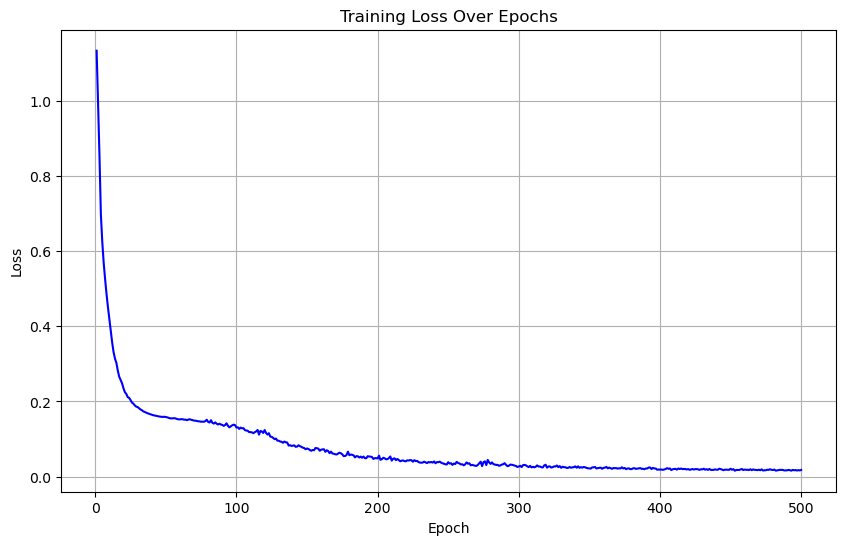

Training complete.


In [7]:
train(
    train_model,
    train_dataloader,
    w_path="/Users/gunneo/Documents/4_2/Graduation_Thesis/Datasets/NYC_House_Price_Dataset/JGC_MMN/train_weights/",
    num_epochs=500,
    optimizer_type='adam',
    lr=5e-3,
    input_indices=[0, 1, 2],
    patience=5,
    save_interval=25,
    loss_threshold=5e-4
)

# 4. Test the result

In [8]:
test_dataset = JGC_MMN_dataloader(
        name=["long_term.npy", "short_term.npy", "ingredients.npy", "future.npy", "label.npy"],
        root="/Users/gunneo/Documents/4_2/Graduation_Thesis/Datasets/NYC_House_Price_Dataset/JGC_MMN/test",
        transaction_cnt=False,
    )
test_dataloader = data.DataLoader(test_dataset, batch_size=11, shuffle=True)
test_global_min = test_dataset.global_min
test_global_max = test_dataset.global_max

In [ ]:
test_model = JGC_MMN(
    branches = [0, 1, 2],
    dense_ori=True,
    # img config
    img_h = img_h,
    img_w = img_w,
    # short term config
    short_term_in_channels = short_term_in_channels,
    short_term_growth_rate = 4,
    short_term_block_config = (6, 12, 24, 16),
    # long term config
    long_term_in_channels = long_term_in_channels,
    long_term_growth_rate = 4,
    long_term_block_config = (6, 12, 24, 16),
    # cur ingredient config
    cur_ingred_dim = cur_ingred_dim,
    emedding_dim = 64,
    # future price growth expectation config
    # fusion config
    modalities = 3,
    indexs = [0, 1],
)

In [10]:
test_model.load_state_dict(torch.load("/Users/gunneo/Documents/4_2/Graduation_Thesis/Datasets/NYC_House_Price_Dataset/JGC_MMN/train_weights/best_model.pth"))

/var/folders/wv/8hm9fpxs3tdgdkp2z_jy1mr40000gn/T/ipykernel_51320/3591100447.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load("/Users

<All keys matched successfully>

In [13]:
def test(
    test_model,
    test_dataloader,
    input_indexs = [0, 1, 2, 3]
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_model = test_model.to(device)
    num_batches = 0
    rmse_total = 0.0
    conversion_rmse_total = 0.0
    with torch.no_grad():
        for batch in test_dataloader:
            inputs = [batch[i].to(device) for i in input_indexs]
            labels = batch[-1].to(device)
            
            predictions = test_model(inputs)
            print("without conversion: ")
            print(predictions[0][0][5])
            print(labels[0][0][4])
            rmse = rmse_loss(predictions, labels)
            rmse_total += rmse.item()
            print('------------------------------------')
            print("with conversion: ")
            predictions = inverse_normalize(predictions, test_global_min[-1][0], test_global_max[-1][0])
            labels = inverse_normalize(labels, test_global_min[-1][0], test_global_max[-1][0])
            print(predictions[0][0][5])
            print(labels[0][0][5])
            conversion_rmse = rmse_loss(predictions, labels)
            conversion_rmse_total += conversion_rmse.item()
            num_batches += 1

    average_rmse = rmse_total / num_batches
    print(f"Average RMSE: {average_rmse}")
    average_conversion_rmse = conversion_rmse_total / num_batches
    print(f"Average Conversion RMSE: {average_conversion_rmse}")

In [14]:
test(test_model, test_dataloader, [0, 1, 2])

without conversion: 
tensor([-0.9994, -0.9994, -0.9994, -0.9993, -0.8066, -0.9977,  0.0455, -0.2929,
        -0.3905, -0.3595, -0.4020, -0.5530])
tensor([-1.0000, -1.0000, -1.0000, -1.0000,  0.1854,  0.2744, -0.2389, -0.0184,
        -0.2049, -0.5061, -0.5674, -0.4659])
------------------------------------
with conversion: 
tensor([5.2933e+02, 5.5482e+02, 5.2175e+02, 5.8021e+02, 1.6847e+05, 1.9622e+03,
        9.1063e+05, 6.1585e+05, 5.3086e+05, 5.5791e+05, 5.2090e+05, 3.8931e+05])
tensor([     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
             0.0000, 812767.6875, 813594.5000, 877758.8125, 757500.0000,
        515672.2812, 434281.8438])
Average RMSE: 0.3642497956752777
Average Conversion RMSE: 317261.5625
